In [1]:
import os
import numpy as np
import pandas as pd

BASE_DIR = os.getcwd()
INPUT_DIR = os.path.join(BASE_DIR, "input")

print("Base directory:", BASE_DIR)
print("Input directory:", INPUT_DIR)

print("\nFiles in input folder:")
for file in os.listdir(INPUT_DIR):
    print(file)

Base directory: /var/www/html/loan-payback-web
Input directory: /var/www/html/loan-payback-web/input

Files in input folder:
train.csv
test.csv
sample_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.neural_network import MLPClassifier
import joblib

In [3]:
train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test  = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub   = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("Sub shape  :", sub.shape)

train.head()

Train shape: (593994, 13)
Test shape : (254569, 12)
Sub shape  : (254569, 2)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
TARGET = "loan_paid_back"
ID_COL = "id"

X = train.drop(columns=[TARGET, ID_COL])
y = train[TARGET]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


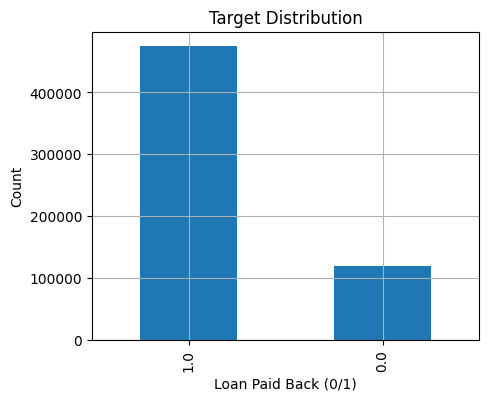

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [5]:
plt.figure(figsize=(5,4))
train[TARGET].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel("Loan Paid Back (0/1)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

train[TARGET].value_counts(normalize=True)

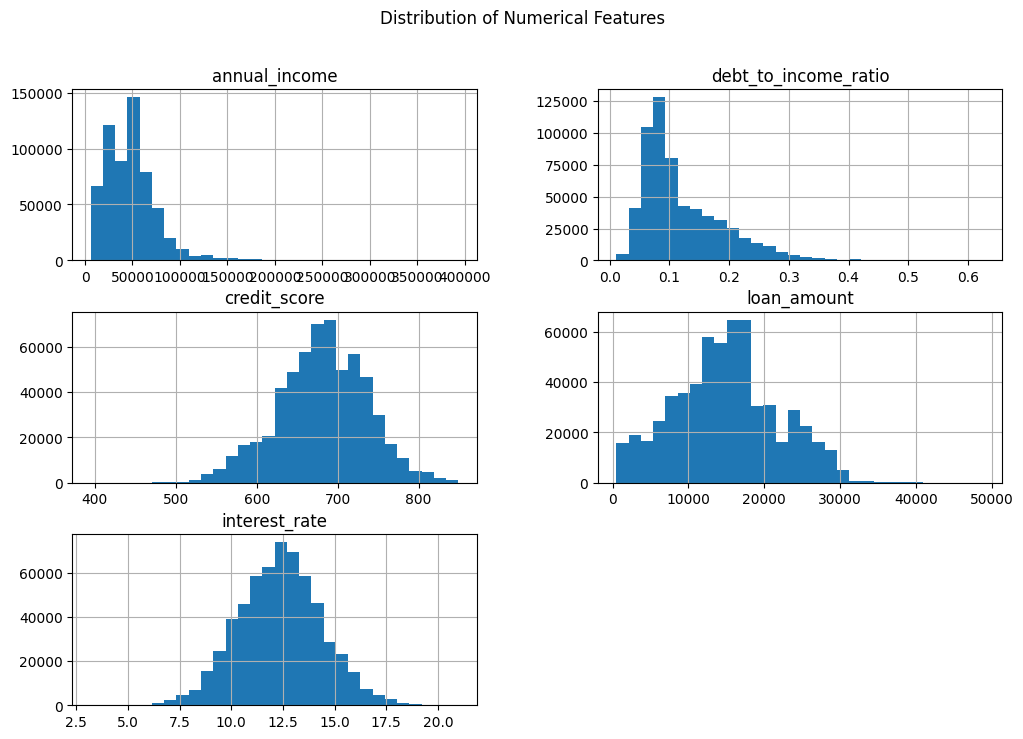

In [6]:
train[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution of Numerical Features")
plt.show()

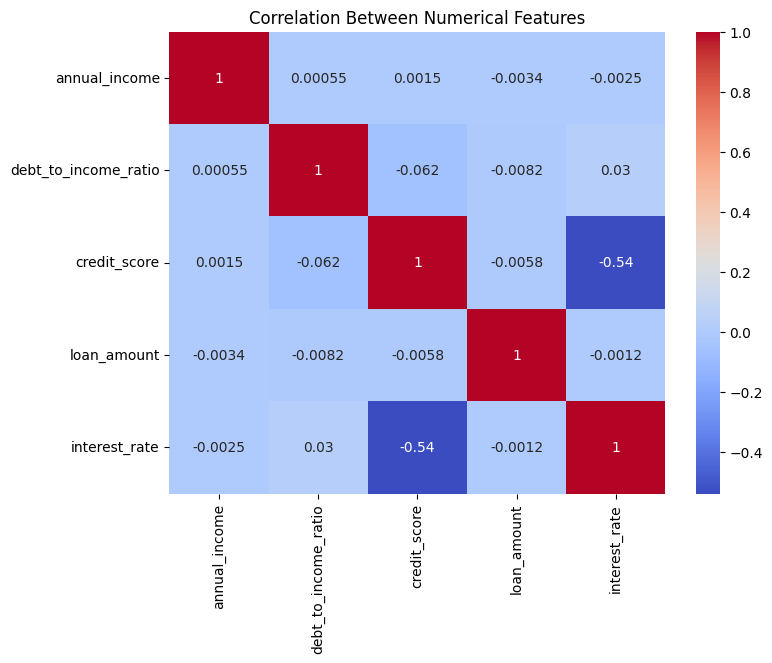

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Numerical Features")
plt.show()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)

(475195, 11) (118799, 11)


In [9]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

mlp_model = Pipeline([
    ("preprocessor", preprocessor),
    ("nn", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42
    ))
])

mlp_model.fit(X_train, y_train)
print("Neural Network trained ✅")

Neural Network trained ✅


In [11]:
y_pred = mlp_model.predict(X_val)
y_prob = mlp_model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_prob))

              precision    recall  f1-score   support

         0.0       0.88      0.59      0.71     23900
         1.0       0.90      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.89      0.79      0.82    118799
weighted avg       0.90      0.90      0.89    118799

ROC-AUC: 0.9116596455487294


In [12]:
mlp_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade'])])),
                ('nn',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32),
                               max_iter=300, random_state=42))])

In [13]:
test_prob = mlp_model.predict_proba(
    test.drop(columns=[ID_COL])
)[:, 1]

submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET: test_prob.astype(float)
})

submission.to_csv("submission.csv", index=False)

print("submission.csv saved ✅")
submission.head()

submission.csv saved ✅


,id,loan_paid_back
0,593994,0.928928
1,593995,0.986530
2,593996,0.419379
3,593997,0.932373
4,593998,0.968824


In [14]:
import joblib

joblib.dump(mlp_model, "loan_payback_nn_model.pkl")

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, "model_columns.pkl")

print("Model & feature columns exported ✅")

Model & feature columns exported ✅


In [15]:
!ls -lh

total 6.8M
-rw-rw-r-- 1 lmarcho lmarcho 2.9K Feb  2 19:25 app.py
drwxrwxr-x 2 lmarcho lmarcho 4.0K Feb  2 19:14 input
-rw-rw-r-- 1 lmarcho lmarcho 155K Feb  2 22:00 loan_payback_nn_model.pkl
-rw-rw-r-- 1 lmarcho lmarcho  196 Feb  2 22:00 model_columns.pkl
-rw-rw-r-- 1 lmarcho lmarcho 215K Feb  2 22:00 notebookb9275237dd.ipynb
-rw-rw-r-- 1 lmarcho lmarcho   57 Feb  2 19:48 requirements.txt
drwxrwxr-x 3 lmarcho lmarcho 4.0K Feb  2 19:03 results
-rw-rw-r-- 1 lmarcho lmarcho 6.4M Feb  2 22:00 submission.csv
drwxrwxr-x 7 lmarcho lmarcho 4.0K Jan 28 00:03 venv
